In [23]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [38]:
data = pickle.load(open(r"C:\Users\grego\Documents\GitHub\DataVizCaptionGeneration\volume\processed\features.pkl", "rb"))
df = pd.DataFrame(data,
columns=[
        # chart type
        'chart_type',

        # label features
        "n_labels",
        "n_num_labels",
        "num_labels_x_mean",
        "num_labels_y_mean",
        "num_labels_x_std",
        "num_labels_y_std",

        # glyph features
        "sizes_mean_large", 
        "sizes_std_large",
        "std_center_x_large", 
        "st_centers_y_large",
        "num_sides_mean_large", 
        "num_sides_std_large",
        "aspect_ratios_mean_large", 
        "aspect_ratios_std_large",
        "num_glyphs_large",
        "std_center_x_small", 
        "std_centers_y_small",
        "num_glyphs_small",
        "aspect_ratios_mean_small", 
        "aspect_ratios_std_small",

        # chart file name
        "chart_fp"
]
)

# df.drop("Unnamed: 0", axis=1, inplace=True)

df.head()

,chart_type,n_labels,n_num_labels,num_labels_x_mean,num_labels_y_mean,num_labels_x_std,num_labels_y_std,sizes_mean_large,sizes_std_large,std_center_x_large,...,num_sides_std_large,aspect_ratios_mean_large,aspect_ratios_std_large,num_glyphs_large,std_center_x_small,std_centers_y_small,num_glyphs_small,aspect_ratios_mean_small,aspect_ratios_std_small,chart_fp
0,fit-density-histogram-plot,9,1,502.500,20.5,0.00000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0,0.000000,0.000000,9,0.386596,0.352604,C:\Users\grego\Documents\GitHub\DataVizCaption...
1,fit-density-histogram-plot,10,5,227.600,522.7,377.45005,351.029002,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0,197.156570,147.051106,57,0.643138,0.505424,C:\Users\grego\Documents\GitHub\DataVizCaption...
2,fit-density-histogram-plot,7,0,0.000,0.0,0.00000,0.000000,32.0,11.0,22.0,...,3.0,0.675050,0.365669,2,230.014981,186.394928,41,1.822045,2.563303,C:\Users\grego\Documents\GitHub\DataVizCaption...
3,fit-density-histogram-plot,18,8,536.625,990.0,299.30803,1.322876,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0,223.973156,126.793645,96,0.781493,0.262061,C:\Users\grego\Documents\GitHub\DataVizCaption...
4,fit-density-histogram-plot,6,2,38.000,278.0,0.00000,115.500000,392.5,0.0,0.0,...,0.0,1.005754,0.000000,1,229.304630,206.642856,29,1.945991,2.572025,C:\Users\grego\Documents\GitHub\DataVizCaption...


In [39]:
# we don't need this column for the analysis
df.drop("chart_fp", axis=1, inplace=True)

# remove nulls
df.dropna(inplace=True)

X = df.drop("chart_type", axis=1)
y = df.chart_type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [40]:
# random forest classifier with hyperparameters tuning
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print("Training score: ", clf.score(X_train, y_train))
print("Testing score: ", clf.score(X_test, y_test))

Training score:  0.9835430405259965
Testing score:  0.8366468378209142


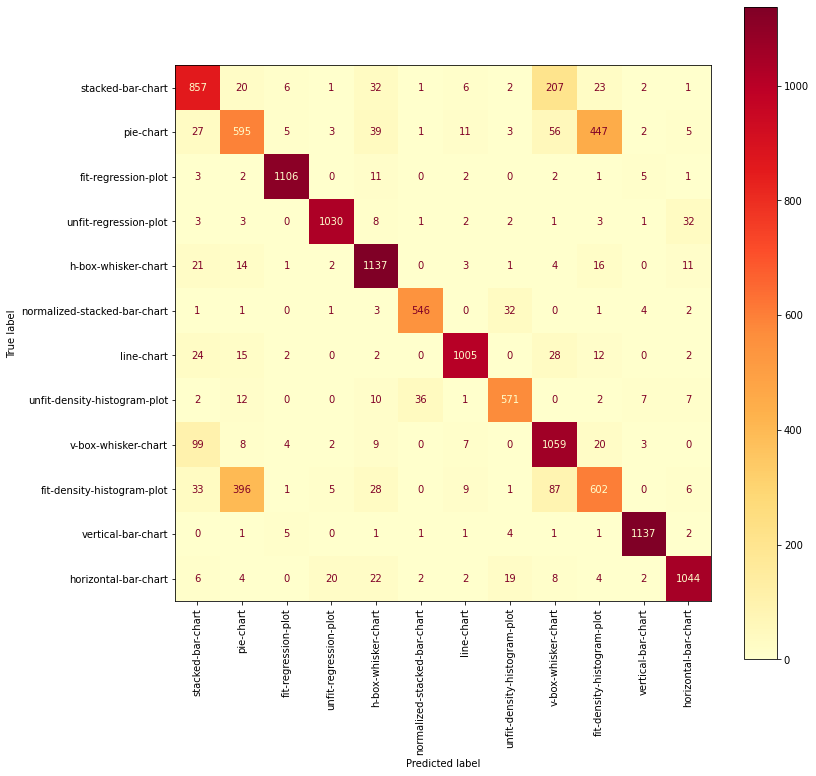

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)

# display confusion matrix
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(1,1, figsize=(12,12))
display.plot(include_values=True, xticks_rotation='vertical', ax=ax, cmap="YlOrRd")
ax.set_xticklabels(set(y_test))
ax.set_yticklabels(set(y_test))

# save to svg
plt.savefig("confusion_matrix.svg")

plt.show()

In [27]:
import pickle
pickle.dump(clf, open(r"C:\Users\grego\Documents\GitHub\DataVizCaptionGeneration\src\models\rf_clf.pkl", "wb"))


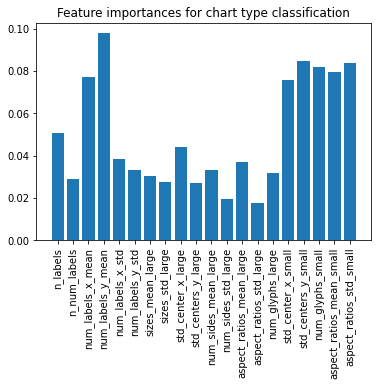

In [9]:
import matplotlib.pyplot as plt

plt.bar(X.columns, clf.feature_importances_, orientation='vertical')
plt.xticks(rotation = 90)
plt.title("Feature importances for chart type classification")
plt.show()

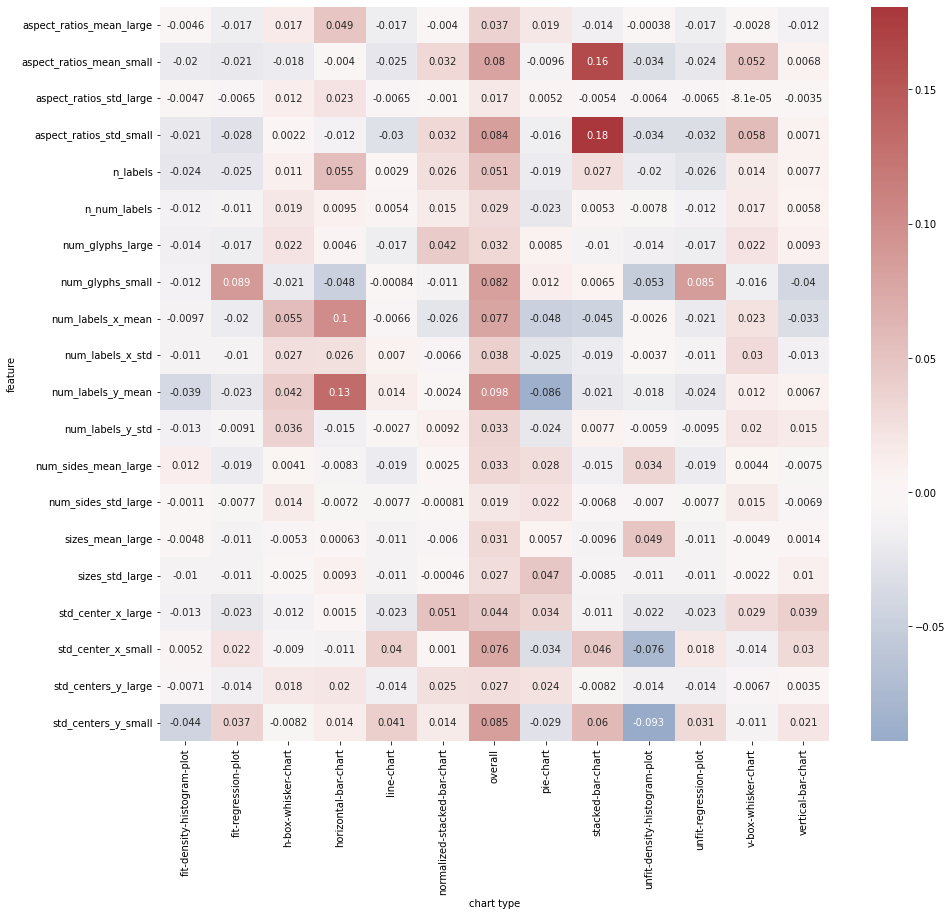

In [10]:
from sklearn.preprocessing import scale
import numpy as np
import seaborn as sns

def class_feature_importance(X, Y, feature_importances):
    # https://stackoverflow.com/questions/35249760/using-scikit-to-determine-contributions-of-each-feature-to-a-specific-class-pred
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(N), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out

# wrnagle data for visualization
data = []
for chart_type, feature_importances in class_feature_importance(X, y, clf.feature_importances_).items():
    for feature, importance in feature_importances.items():
        data.append([chart_type, X.columns[feature], importance])

# add overall importances
for feature, importance in enumerate(clf.feature_importances_):
    data.append(["overall", X.columns[feature], importance])

importances = pd.DataFrame(data, columns=["chart type", "feature", "importance"])

# plot
fig, ax = plt.subplots(1,1, figsize=(15,15))
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(importances.pivot("feature", "chart type", "importance"),
            annot=True,
            center=0.00,
            ax=ax,
            cmap=cmap
            )
plt.subplots_adjust(bottom=0.2)
plt.savefig("feature_importances.svg")